# **Homework 2**

**Equipe**:

**Kelvin Leandro Martins - 540006**

**Pedro Leinos Falcão Cunha - 542114**

## Imports

In [ ]:
# download files
! wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1b9y1x9cEv9qjVtSpLUDaFy4uEtI74QDJ' -O assets.zip
! unzip assets.zip

--2024-08-28 22:40:54--  https://docs.google.com/uc?export=download&id=1b9y1x9cEv9qjVtSpLUDaFy4uEtI74QDJ
Resolving docs.google.com (docs.google.com)... 108.177.127.102, 108.177.127.139, 108.177.127.138, ...
Connecting to docs.google.com (docs.google.com)|108.177.127.102|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1b9y1x9cEv9qjVtSpLUDaFy4uEtI74QDJ&export=download [following]
--2024-08-28 22:40:55--  https://drive.usercontent.google.com/download?id=1b9y1x9cEv9qjVtSpLUDaFy4uEtI74QDJ&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 108.177.119.132, 2a00:1450:4013:c1a::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|108.177.119.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1817 (1.8K) [application/octet-stream]
Saving to: ‘assets.zip’

assets.zip          100%[===================>]   1.77K  --.-KB/s    in

In [ ]:
!pip install control
import control as ctrl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.6/549.6 kB 9.1 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
from scipy.linalg import solve_continuous_lyapunov
from sympy import symbols, limit, solve, latex
from IPython.display import display, Math

## Exercise 1 ok

The unit steps responses of two systems A and B are recorded and reported in the
files attached to the homework assignment. In each file, the first column gives the time vector, t, and the second column provides the output response, *y(t)*, for the systems A (in *HW2_ex1_dataA.txt*) and B (in *HW2_ex1_dataB.txt*). Do the following

### 1.1

Load the data and plot the responses for systems A and B

In [ ]:
data_a = pd.read_csv('HW2_ex1_dataA.csv', header=None, names=["time", "response"])
data_b = pd.read_csv('HW2_ex1_dataB.csv', header=None, names=["time", "response"])

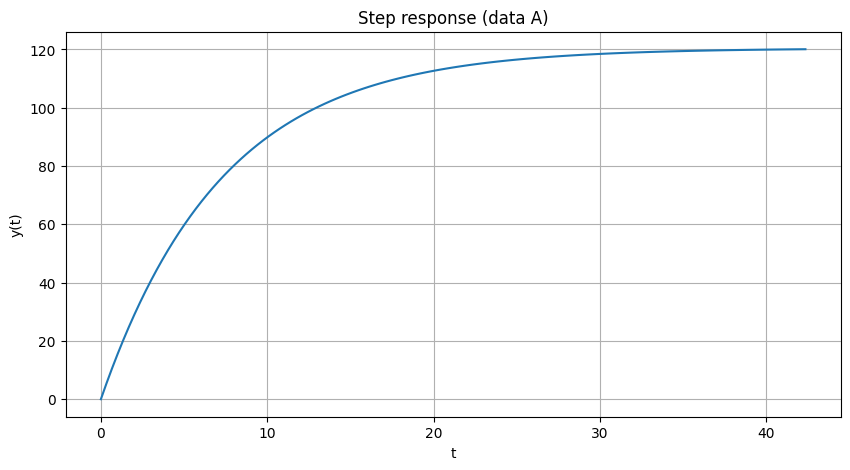

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(data_a["time"], data_a["response"])
plt.xlabel('t')
plt.ylabel('y(t)')
plt.title('Step response (data A)')
plt.grid()
plt.show()

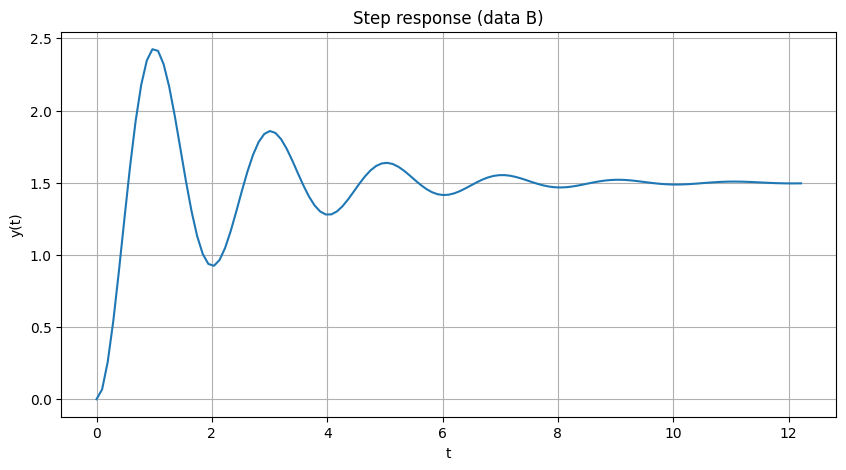

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(data_b["time"], data_b["response"])
plt.xlabel('t')
plt.ylabel('y(t)')
plt.title('Step response (data B)')
plt.grid()
plt.show()

### 1.2

Identify the order of the systems. Based on the plots, estimate the transient response characteristics, such as time constant, settling time, rise time, peak time and percentage of overshoot. Write the corresponding transfer functions $T_A(s)$ and $T_B(s)$ for the systems A and B

In [ ]:
def find_settling_time_index(df, range_value, steady_state):
  for i in range(len(df) - 1, 0, -1):
    if not (steady_state - range_value <= df["response"].iloc[i-1] <= steady_state + range_value):
      return i
  return 0

#### System A

In [ ]:
# Steady state value
steady_state_a = data_a["response"].iloc[-1]

# Time constant calculation (63.2% criterion)
sixty_three_perc = 0.632 * steady_state_a
time_constant_index = data_a.index[(data_a["response"] >= sixty_three_perc)].to_list()[0]
time_constant_a = data_a["time"].loc[time_constant_index]

# Rise time calculation (10% and 90% criterion)
ten_perc = 0.1 * steady_state_a
ninety_perc = 0.9 * steady_state_a
time_at_10_perc_a = data_a.loc[data_a["response"] >= ten_perc, "time"].iloc[0]
time_at_90_perc_a = data_a.loc[data_a["response"] >= ninety_perc, "time"].iloc[0]
rise_time_a = time_at_90_perc_a - time_at_10_perc_a

# Settling time calculation (2% criterion)
two_perc_range = 0.02 * steady_state_a
settling_time_index = find_settling_time_index(data_a, two_perc_range, steady_state_a)
settling_time_a = data_a["time"].loc[settling_time_index]

# Transfer Function
num = [steady_state_a]
den = [time_constant_a, 1]
tf_a = signal.TransferFunction(num, den)

print(f"Time constant: {time_constant_a}")
print(f"Rise time: {rise_time_a}")
print(f"Settling time: {settling_time_a}")
print(f"Transfer Function: {tf_a}")

Time constant: 7.3959
Rise time: 15.800400000000002
Settling time: 27.5665
Transfer Function: TransferFunctionContinuous(
array([16.23686096]),
array([1.        , 0.13521005]),
dt: None
)


In [ ]:
ctrl.step_info(data_a["response"],T=data_a["time"])

{'RiseTime': 15.800400000000002,
 'SettlingTime': 27.5665,
 'SettlingMin': 108.405,
 'SettlingMax': 120.0862,
 'Overshoot': 0,
 'Undershoot': 0,
 'Peak': 120.0862,
 'PeakTime': 42.3584,
 'SteadyStateValue': 120.0862}

#### System B

In [ ]:
# Max and steady state values
max = data_b["response"].max()
steady_state_b = data_b["response"].iloc[-1]

# Peak time
peak_index_b = data_b["response"].idxmax()
peak_time_b = data_b["time"].loc[peak_index_b]

# Overshoot and Damping ratio (zeta) calculation
overshoot = ((max - steady_state_b) / steady_state_b)
ln_overshoot = np.log(overshoot)
zeta = -ln_overshoot / np.sqrt(np.pi**2 + ln_overshoot**2)

# Natural frequency (Omega n)
wn = np.pi / (peak_time_b * np.sqrt(1 - zeta**2))

# Settling time calculation (2% criterion)
two_perc_range = 0.02 * steady_state_b
settling_time_index = find_settling_time_index(data_b, two_perc_range, steady_state_b)
settling_time_b = data_b["time"].loc[settling_time_index]

# Rise time calculation (10% and 90% criterion)
ten_perc = 0.1 * steady_state_b
ninety_perc = 0.9 * steady_state_b
time_at_10_perc_b = data_b.loc[data_b["response"] >= ten_perc, "time"].iloc[0]
time_at_90_perc_b = data_b.loc[data_b["response"] >= ninety_perc, "time"].iloc[0]
rise_time_b = time_at_90_perc_b - time_at_10_perc_b

# Transfer function
num = [steady_state_b * wn**2]
den = [1, 2*zeta*wn, wn**2]
tf_b = signal.TransferFunction(num, den)

print(f"max: {max}")
print(f"peak_time_b: {peak_time_b}")
print(f"steady_state_b: {steady_state_b}")
print(f"Damping ratio (zeta): {zeta}")
print(f"Natural frequency (wn): {wn}")
print(f"Rise time: {rise_time_b}")
print(f"Peak time: {peak_time_b}")
print(f"Overshoot: {overshoot}")
print(f"Settling time: {settling_time_b}")
print(f"Transfer Function: {tf_b}")

max: 2.4248
peak_time_b: 0.9695
steady_state_b: 1.4957
Damping ratio (zeta): 0.14984670976706022
Natural frequency (wn): 3.277430310696813
Rise time: 0.38780000000000003
Peak time: 0.9695
Overshoot: 0.621180718058434
Settling time: 7.4652
Transfer Function: TransferFunctionContinuous(
array([16.0661355]),
array([ 1.        ,  0.9822243 , 10.74154944]),
dt: None
)


In [ ]:
ctrl.step_info(data_b["response"],T=data_b["time"])

{'RiseTime': 0.38780000000000003,
 'SettlingTime': 7.4652,
 'SettlingMin': 0.9245,
 'SettlingMax': 2.4248,
 'Overshoot': 62.11807180584341,
 'Undershoot': 0,
 'Peak': 2.4248,
 'PeakTime': 0.9695,
 'SteadyStateValue': 1.4957}

### 1.3

In the plot obtained in item (1) of this exercise, add and compare the unit step response of the systems $T_A(s)$ with the data provided in *HW2_ex1_dataA.csv*. Do the same with the unit step response of $T_B(s)$ with the data provided in *HW2_ex1_dataB.csv*. Comment on your results

In [ ]:
t = np.linspace(0, data_a["time"].iloc[-1], 1000)
t, y = signal.step(tf_a, T=t)

plt.figure(figsize=(10, 5))
plt.plot(data_a["time"], data_a["response"], label='original')
plt.plot(t, y, label='simulation')
plt.axvline(x=time_constant_a, color='b', linestyle='--', linewidth=1, label='time constant')
plt.axvline(x=time_at_10_perc_a, color='g', linestyle='--', linewidth=1, label='10% rise start')
plt.axvline(x=time_at_90_perc_a, color='m', linestyle='--', linewidth=1, label='90% rise end')
plt.axvline(x=settling_time_a, color='r', linestyle='--', linewidth=1, label='settling time')
plt.xlabel('t')
plt.ylabel('y(t)')
plt.title('Step response (data A)')
plt.legend()
plt.grid()
plt.show()

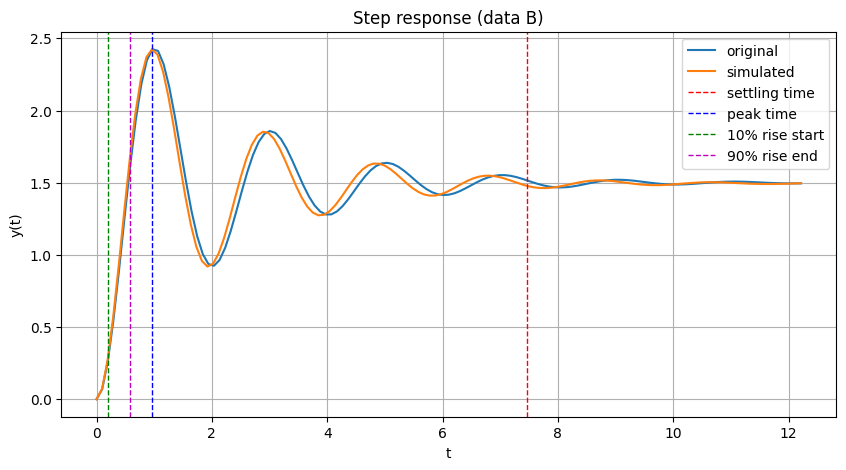

In [ ]:
t = np.linspace(0, data_b["time"].iloc[-1], 128)
t, y = signal.step(tf_b, T=t)

# Plot the response
plt.figure(figsize=(10, 5))
plt.plot(data_b["time"], data_b["response"], label='original')
plt.plot(t, y, label='simulated')
plt.axvline(x=settling_time_b, color='r', linestyle='--', linewidth=1, label='settling time')
plt.axvline(x=peak_time_b, color='b', linestyle='--', linewidth=1, label='peak time')
plt.axvline(x=time_at_10_perc_b, color='g', linestyle='--', linewidth=1, label='10% rise start')
plt.axvline(x=time_at_90_perc_b, color='m', linestyle='--', linewidth=1, label='90% rise end')
plt.title('Step response (data B)')
plt.xlabel('t')
plt.ylabel('y(t)')
plt.grid(True)
plt.legend()
plt.show()

## Exercise 2 ok

Consider a system with the transfer function in:

$$G(s) = \frac{\tau s + 1}{(0.1s + 1)(0.002s^2 + 0.02s + 1)(s^2 + 0.1s + 1)}$$

Consider two different cases with (i) $\tau = 0.5$ and (ii)
$\tau = 20$. For each case separately, do the following

### 2.1

Find the poles and zeros of the system. Plot them in a zero-pole map and draw your conclusions

In [ ]:
def print_poles(poles):
    for pole in poles:
        real = pole.real
        imag = pole.imag

        if imag == 0:
            print(f"  {real:.2f}")
        elif imag > 0:
            print(f"  {real:.2f} + {imag:.2f}j")
        else:
            print(f"  {real:.2f} - {abs(imag):.2f}j")

In [ ]:
def analyze_system(tau):
  num = [tau, 1]
  den = np.convolve([0.1, 1],
        np.convolve([0.002, 0.02, 1], [1, 0.1, 1]))

  G = signal.TransferFunction(num, den)

  # Step response
  t, y = signal.step(G, T=np.linspace(0, 140, 1000))

  # Pole-zero map
  poles = np.roots(den)
  zeros = np.roots(num)

  # Pole-zero map
  plt.plot(np.real(poles), np.imag(poles), 'x', markersize=10, label='Poles')
  plt.plot(np.real(zeros), np.imag(zeros), 'o', markersize=10, label='Zeros')
  plt.title(f'Pole-Zero Map (τ = {tau})')
  plt.xlabel('Real')
  plt.ylabel('Imaginary')
  plt.grid(True)
  plt.legend()
  plt.axhline(y=0, color='k', linewidth=1)
  plt.axvline(x=0, color='k', linewidth=1)

  plt.tight_layout()
  plt.show()

  # Print poles and zeros
  print(f"Poles (τ = {tau}):")
  print_poles(poles)
  print(f"\nZeros (τ = {tau}):")
  print(zeros)

  return {
      "tau": tau,
      "time": t,
      "response": y,
      "poles": poles,
      "zeros": zeros
  }

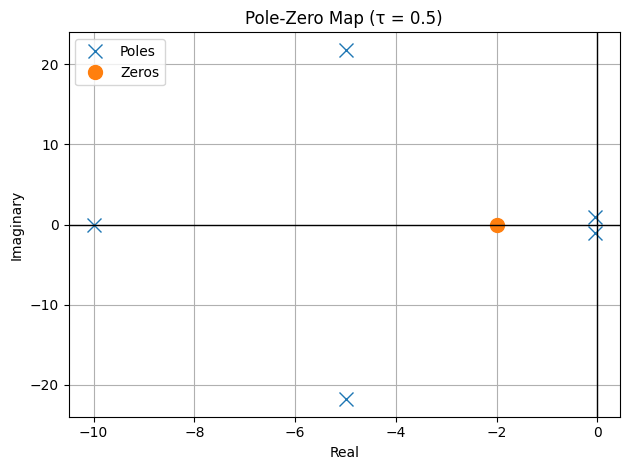

Poles (τ = 0.5):
  -5.00 + 21.79j
  -5.00 - 21.79j
  -10.00
  -0.05 + 1.00j
  -0.05 - 1.00j

Zeros (τ = 0.5):
[-2.]


In [ ]:
# Analyze for τ = 0.5
analysis_05 = analyze_system(0.5)

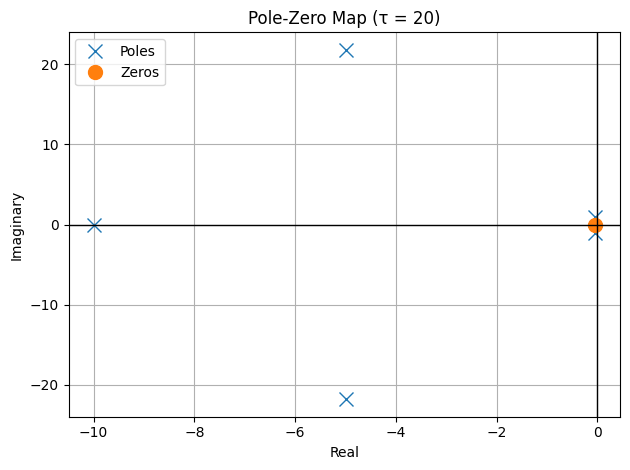

Poles (τ = 20):
  -5.00 + 21.79j
  -5.00 - 21.79j
  -10.00
  -0.05 + 1.00j
  -0.05 - 1.00j

Zeros (τ = 20):
[-0.05]


In [ ]:
# Analyze for τ = 20
analysis_20 = analyze_system(20)

### 2.2
Use the dominant-poles argument to find an equivalent second-order transfer function. Can the zero be neglected in this case?

In [ ]:
def find_dominant_poles(poles):
  # Dominant poles are those with the smallest real parts (closest to the imaginary axis)
  sorted_poles = sorted(poles, key=lambda p: np.abs(np.real(p)))
  return sorted_poles[:2]

def second_order_approximation(dominant_poles):
  s1, s2 = dominant_poles # typically complex conjugates
  wn = np.sqrt(np.real(s1)**2 + np.imag(s1)**2) # natural frequency

  num = [wn ** 2]
  den = [1, 2 * (-np.real(s1) / wn) * wn, wn ** 2]
  tf = signal.TransferFunction(num, den)

  return wn, -np.real(s1) / wn, tf

def analyze_equivalent_second_order_system(tau, analysis):
  poles = analysis["poles"]
  zeros = analysis["zeros"]

  dominant_poles = find_dominant_poles(poles)
  wn, zeta, tf = second_order_approximation(dominant_poles)

  print(f"Tau: {tau}")
  print(f"Dominant Poles: {dominant_poles}")
  print(f"Natural Frequency (ω_n): {wn}")
  print(f"Damping Ratio (ζ): {zeta}\n")

  print(f"Transfer Function: {tf}\n")

  # Check if the zero can be neglected
  zero = zeros[0]

  print(f"Real part of the zero: {np.real(zero)}")
  print(f"Real part of the dominant pole * 5: {np.real(dominant_poles[0]) * 5}\n")

  if np.abs(np.real(zero)) > 5 * np.abs(np.real(dominant_poles[0])):
    print("The zero can be neglected in this case.")
  else:
    print("The zero cannot be neglected in this case.")

  return tf

In [ ]:
tf_05 = analyze_equivalent_second_order_system(0.5, analysis_05)

# num = [0.5, 1]
# den = [1, 0.1, 1]
# tf05 = signal.TransferFunction(num, den)

Tau: 0.5
Dominant Poles: [(-0.049999999999999864+0.9987492177719091j), (-0.049999999999999864-0.9987492177719091j)]
Natural Frequency (ω_n): 1.0
Damping Ratio (ζ): 0.049999999999999864

Transfer Function: TransferFunctionContinuous(
array([1.]),
array([1. , 0.1, 1. ]),
dt: None
)

Real part of the zero: -2.0
Real part of the dominant pole * 5: -0.24999999999999933

The zero can be neglected in this case.


In [ ]:
tf_20 = analyze_equivalent_second_order_system(20, analysis_20)

# num = [20, 1]
# den = [1, 0.1, 1]
# tf20 = signal.TransferFunction(num, den)

Tau: 20
Dominant Poles: [(-0.049999999999999864+0.9987492177719091j), (-0.049999999999999864-0.9987492177719091j)]
Natural Frequency (ω_n): 1.0
Damping Ratio (ζ): 0.049999999999999864

Transfer Function: TransferFunctionContinuous(
array([1.]),
array([1. , 0.1, 1. ]),
dt: None
)

Real part of the zero: -0.05
Real part of the dominant pole * 5: -0.24999999999999933

The zero cannot be neglected in this case.


### 2.3

Plot and compare the step responses for system in equation (1) and the second order equivalent one. Explain and justify the differences between the responses

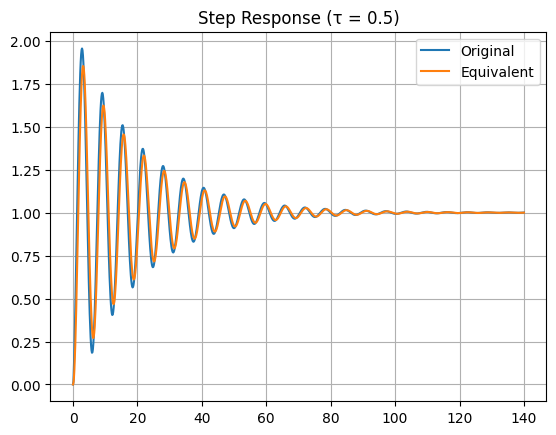

In [ ]:
t, y = signal.step(tf_05, T=analysis_05["time"])

plt.plot(analysis_05["time"], analysis_05["response"], label='Original')
plt.plot(t, y, label='Equivalent')
plt.title(f'Step Response (τ = {0.5})')
plt.legend()
plt.grid()
plt.show()

In [ ]:
# num = [1]
# den = [1, 0.1, 1]
# tf05 = signal.TransferFunction(num, den)

# t, y = signal.step(tf05, T=analysis_05["time"])

# plt.plot(analysis_05["time"], analysis_05["response"], label='Original')
# plt.plot(t, y, label='Equivalent')
# plt.title(f'Step Response (τ = {0.5})')
# plt.legend()
# plt.grid()
# plt.show()

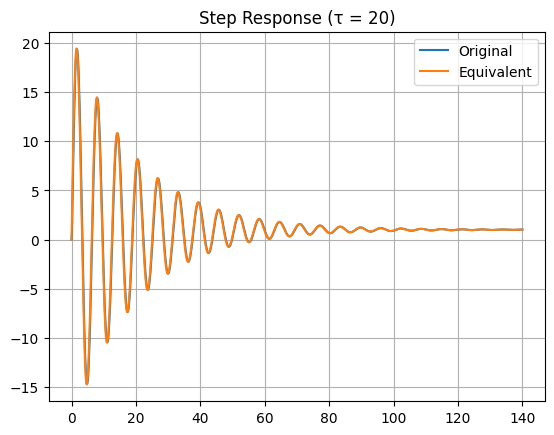

In [ ]:
num = [20, 1]
den = [1, 0.1, 1]
tf20 = signal.TransferFunction(num, den)

t, y = signal.step(tf20, T=analysis_20["time"])

plt.plot(analysis_20["time"], analysis_20["response"], label='Original')
plt.plot(t, y, label='Equivalent')
plt.title(f'Step Response (τ = {20})')
plt.legend()
plt.grid()
plt.show()

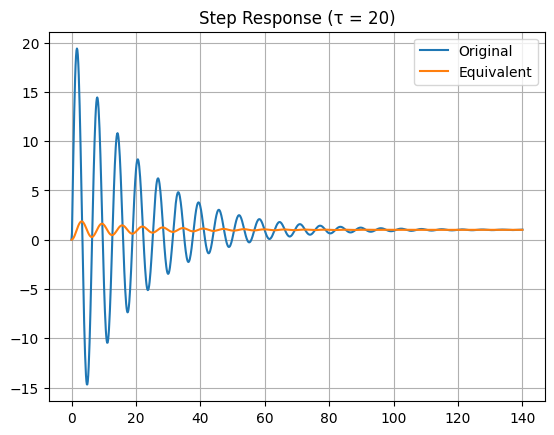

In [ ]:
# t, y = signal.step(tf_20, T=analysis_20["time"])

# plt.plot(analysis_20["time"], analysis_20["response"], label='Original')
# plt.plot(t, y, label='Equivalent')
# plt.title(f'Step Response (τ = {20})')
# plt.legend()
# plt.grid()
# plt.show()

## Exercise 3

It is given the state-space model in

$$
\left\{
\begin{array}{l}
\begin{bmatrix}
\dot{x}_1(t) \\
\dot{x}_2(t)
\end{bmatrix}
=
\begin{bmatrix}
0 & 1 \\
-5 & -2
\end{bmatrix}
\begin{bmatrix}
x_1(t) \\
x_2(t)
\end{bmatrix}
+
\begin{bmatrix}
0 \\
2
\end{bmatrix}
u(t) \\
y(t) =
\begin{bmatrix}
0 & 1
\end{bmatrix}
\begin{bmatrix}
x_1(t) \\
x_2(t)
\end{bmatrix}
\end{array}
\right.
$$

### 3.1

Compute and explain the transfer function corresponding to the system in

In [ ]:
A = np.array([[0, 1], [-5, -2]])
B = np.array([[0], [2]])
C = np.array([[0, 1]])
D = np.array([[0]])
tf = ctrl.ss2tf(A, B, C, D)
print(tf)

<TransferFunction>: sys[1]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


2 s + 2.665e-15
---------------
 s^2 + 2 s + 5



### 3.2

Briefly explain the concept of bounded-input, bounded-output (BIBO) stability. Evaluate BIBO stability for the given system

In [ ]:
poles = tf.poles()
print(f"Poles: {poles}")
bibo_stable = all(np.real(poles) < 0)
print(f"BIBO Stable: {bibo_stable}")

Poles: [-1.+2.j -1.-2.j]
BIBO Stable: True


### 3.3

Briefly explain the concept of Lyapunov stability. Evaluate Lyapunov stability for the given system

In [ ]:
eigenvalues = np.linalg.eigvals(A)
print(f"Eigenvalues: {eigenvalues}") # identical to the system poles
lyapunov_stable = all(np.real(eigenvalues) < 0)
print(f"Lyapunov Stable: {lyapunov_stable}")

Eigenvalues: [-1.+2.j -1.-2.j]
Lyapunov Stable: True


### 3.4

Discuss how BIBO stability theory and Lyapunov stability differ for LTI systems. Compare and explain the results of item (2) and (3) of this exercise

In [ ]:
# Theory

In [ ]:
# continuous problem: A.T * P + P*A = -Q
Q = np.eye(2)
P = solve_continuous_lyapunov(A.T, -Q)

# Check if P is positive definite
is_positive_definite = np.all(np.linalg.eigvals(P) > 0)

print("P matrix:")
print(P)
print(f"Is P symmetric? {np.allclose(P, P.T)}")
print(f"Is P positive definite? {is_positive_definite}")

P matrix:
[[1.7 0.1]
 [0.1 0.3]]
Is P symmetric? True
Is P positive definite? True


## Exercise 4

The unity feedback system has the forward transfer function given by

$$G(s) = \frac{K(s+7)}{s(s^3+25s^2+196s+480)}$$

### 4.1

Evaluate the system type

In [ ]:
# Type 1: one pole at origin
num = [1, 7]
den = np.convolve([1, 0], [1, 25, 196, 480])
G = signal.TransferFunction(num, den)
print(f"Poles: {G.poles}")

Poles: [-12.  -8.  -5.   0.]


### 4.2

Find the value of K to yield a 1% error in steady-state for an input of 0.1t

In [ ]:
s, K = symbols('s K')

A = 0.1  # Slope of the ramp input
ess = 0.01  # Desired steady-state error

G_s = K * (s + 7) / (s * (s**3 + 25*s**2 + 196*s + 480))

Kv = A / ess
Kv_eq = limit(s * G_s, s, 0)
eq = Kv - Kv_eq

K_value = solve(eq, K)[0]

display(Math('K = ' + latex(K_value)))

<IPython.core.display.Math object>

In [ ]:
# Nise ch7p2 (Appendix B)

# Define numerator of G(s)/K.
numgdK = np.array([1, 7])

# Define denominator of G(s)/K.
dengdK = np.convolve([1, 0], [1, 25, 196, 480])

# Create G(s)/K.
GdK = ctrl.TransferFunction(numgdK, dengdK)

# Define numerator of sG(s)/K.
numgkv = np.convolve([1, 0], numgdK)

# Define denominator of sG(s)/K.
dengkv = dengdK

# Create sG(s)/K.
GKv = ctrl.TransferFunction(numgkv, dengkv)

# Cancel common 's' in numerator and denominator of sG(s)/k.
GKv = ctrl.minreal(GKv, verbose=False)

# Evaluate (Kv/K) = (numgkv/dengkv) for s=0.
KvdK = ctrl.dcgain(GKv)

# Enumerate steady-state error.
ess = 0.01

# Solve for K.
K_value = 0.1 / (ess * KvdK)
print(f"K = {K_value}")

K = 685.7142857142853


### 4.3

Find the static error constants for the value of K found in item (2) of this exercise

In [ ]:
# G_s = K * (s + 7) / (s * (s**3 + 25*s**2 + 196*s + 480))
G_s = G_s.subs({K: K_value})

K_p = limit(G_s, s, 0)
K_v = limit(s * G_s, s, 0)
K_a = limit(s**2 * G_s, s, 0)

display(Math('K_p = ' + latex(K_p)))
display(Math('K_v = ' + latex(K_v)))
display(Math('K_a = ' + latex(K_a)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

### 4.4

Verify the stability of your system and plot its step response

In [ ]:
# Nise ch7p2 (Appendix B)
# Check stability

# Form T(s).
T = ctrl.feedback(K_value * GdK, 1)

# Display closed-loop poles.
poles = ctrl.poles(T)
print(f"Closed-loop poles = {poles}")

Closed-loop poles = [-16.22371199+0.j         -7.09614714+0.j         -0.84007044+6.4021704j
  -0.84007044-6.4021704j]


In [ ]:
def routh_hurwitz(coeffs):
    """
    Calculates the Routh-Hurwitz stability criterion.

    Parameters:
        coeffs (list or array): Coefficients of the polynomial,
                                starting with the highest degree term.

    Returns:
        routh_array (2D list): The Routh array.
        is_stable (bool): True if the system is stable, False otherwise.
    """
    n = len(coeffs)
    routh_array = np.zeros((n, (n + 1) // 2))

    # First two rows
    routh_array[0, :len(coeffs[0::2])] = coeffs[0::2]  # even indexed coefficients
    routh_array[1, :len(coeffs[1::2])] = coeffs[1::2]  # odd indexed coefficients

    # Fill the rest of the array
    for i in range(2, n):
        for j in range(routh_array.shape[1] - 1):
            if routh_array[i-1, 0] == 0:
                routh_array[i-1, 0] = 1e-6  # Avoid division by zero
            routh_array[i, j] = (routh_array[i-1, 0] * routh_array[i-2, j+1] -
                                 routh_array[i-2, 0] * routh_array[i-1, j+1]) / routh_array[i-1, 0]

    # Check stability
    is_stable = np.all(np.sign(routh_array[:, 0]) == np.sign(routh_array[0, 0]))

    return routh_array, is_stable

In [ ]:
routh_array, is_stable = routh_hurwitz(T.den[0][0])
print("Routh Array:")
print(routh_array)
print("Is the system stable?", is_stable)

In [ ]:
t, y = ctrl.step_response(T, T=np.linspace(0, 10, 500))
plt.plot(t, y)
plt.title('Step Response Feedback System')
plt.xlabel('Time (s)')
plt.ylabel('Response')
plt.grid(True)
plt.show()